In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
sns.set(palette='Set2', font_scale=1.5)
import random

import torch
from torch import nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

print(torch.__version__)

2.5.1+cu121


Скачка данных

In [2]:
!wget -O ./data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-11-27 14:03:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘./data.txt.zip’

./data.txt.zip          [                <=> ] 201.24M  63.1MB/s    in 3.2s    

2024-11-27 14:03:48 (63.1 MB/s) - ‘./data.txt.zip’ saved [211011981]



Проверка данных

In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Взято деление на обучающую и тестовую выборки из задания:

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [5]:
# можете использовать данные пайплан деления данных, можете использовать свой.
train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

Проверка размерности

In [6]:
print(X_train.shape)
print(y_train.shape)

(463715, 90)
(463715,)


Отрисуем график зависимости года, допустим, от самого первого признака в датафрейме, чтобы проанализировать законометрность

Text(0, 0.5, 'Год выпуска песни')

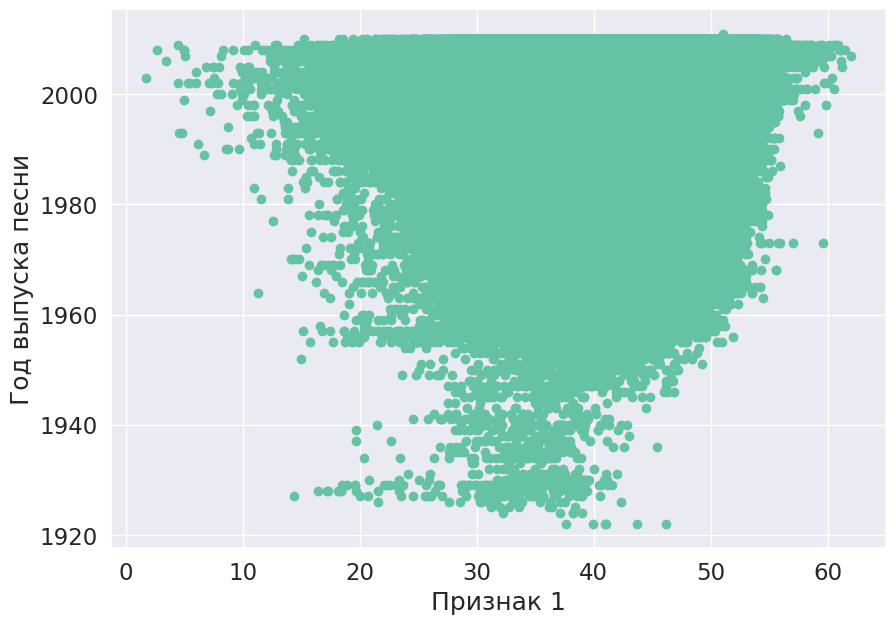

In [7]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], y)
plt.xlabel("Признак 1")
plt.ylabel("Год выпуска песни")

На графике виден широкий разброс в 20-х годах и более плотные(частые) значения в 2000-х. Допустим, это может говорить о меньшем количестве разнообразия стилей музыки

Попробую аналогично применить график к последнему признаку, возможно что-то изменится

Text(0, 0.5, 'Год выпуска песни')

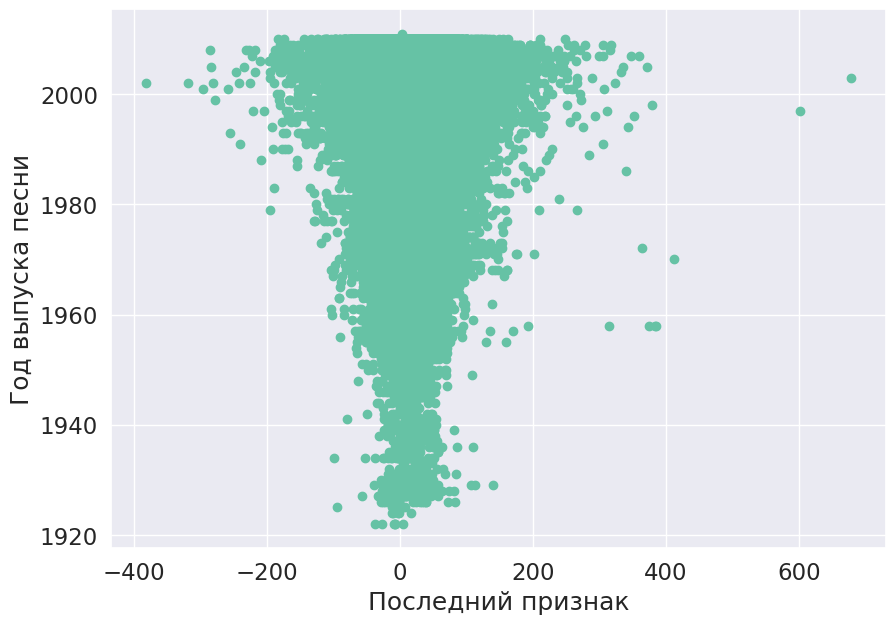

In [8]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, -1], y)
plt.xlabel("Последний признак")
plt.ylabel("Год выпуска песни")

На выше преведенном графикк можно увидеть обратную зависимость: при увеличении значения признака выпуск песен более старых годов становится менее вероятным.
Как и в первом графике, большинство точек сосредоточено в верхней части (1980-2000 гг), данные признаки наиболее характерны для современных песен.

Фиксация для воспроизводительности

In [9]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [10]:
set_random_seed(42)

Масштабирование данных

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
print(X_train.shape)

(463715, 90)


In [13]:
X_test.shape

(51630, 90)

In [14]:
y_test.shape

(51630,)

Преобразование признаков в torch тензоры

In [15]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

In [16]:
print(X_train_tensor)
print(y_train_tensor)

tensor([[ 1.0788,  0.3916,  1.8270,  ..., -0.4705, -0.2554,  0.0426],
        [ 0.8795,  0.3326,  1.7490,  ...,  0.5709,  0.2093,  1.1611],
        [ 1.2455,  0.5928,  1.3375,  ..., -0.3381,  0.1078, -0.0901],
        ...,
        [ 0.1630,  0.0071,  0.8370,  ..., -0.6639,  0.0146, -0.2464],
        [ 0.2470,  0.2497, -0.4071,  ...,  0.5349,  0.4700,  0.7024],
        [ 1.1410,  0.1056,  1.2876,  ..., -0.0501, -0.3391, -0.0576]])
tensor([[2001.],
        [2001.],
        [2001.],
        ...,
        [2007.],
        [2006.],
        [2007.]])


In [17]:
print(X_test_tensor)
print(y_test_tensor)

tensor([[ 0.3383, -0.6202,  0.6561,  ..., -0.6236,  0.0903,  0.2654],
        [ 1.5286, -0.0804,  1.0011,  ..., -0.6347, -0.4799, -0.2966],
        [ 0.3877,  0.2085,  0.0675,  ..., -1.1538,  0.0379, -0.3226],
        ...,
        [ 0.2867,  0.2208, -1.3433,  ..., -0.7895,  0.1852, -0.4272],
        [ 0.1284,  0.6030, -0.3403,  ...,  1.1919, -0.0266,  1.7430],
        [ 1.3936,  1.1209,  0.5032,  ..., -0.7477,  0.0683,  0.4922]])
tensor([[2007.],
        [2003.],
        [2005.],
        ...,
        [2006.],
        [2006.],
        [2005.]])


In [18]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([463715, 90]), torch.Size([463715, 1]))

Проверка на нули

In [19]:
torch.isnan(X_test_tensor).any(), torch.isinf(X_test_tensor).any()

(tensor(False), tensor(False))

Создание модели

In [29]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(1, 1)
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        x = self.fc4(x)
        return x


In [30]:
input_dim = X_train_tensor.shape[1]
model = LinearRegressionModel(input_dim)

In [31]:
print(model)

LinearRegressionModel(
  (fc1): Linear(in_features=90, out_features=128, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=1, out_features=1, bias=True)
)


In [32]:
for param in model.parameters():
  print(param.shape)

torch.Size([128, 90])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])
torch.Size([1, 1])
torch.Size([1])


In [33]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

fc1.weight 	 torch.Size([128, 90])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([64, 128])
fc2.bias 	 torch.Size([64])
fc3.weight 	 torch.Size([1, 64])
fc3.bias 	 torch.Size([1])
fc4.weight 	 torch.Size([1, 1])
fc4.bias 	 torch.Size([1])


Функция потерь и lr

In [34]:
lr=0.09
def optim_func(y_pred, y_true):
  return torch.mean((y_true - y_pred)**2)

Цикл обучения

In [38]:
train_losses = []
train_rmses = []
test_losses = []
test_rmses = []

for epoch in range(10):
    model.train()
    y_pred = model(X_train_tensor)
    loss = optim_func(y_pred, y_train_tensor)
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p -= lr * p.grad

    model.zero_grad()

    train_losses.append(loss)

    rmse = torch.sqrt(loss)
    train_rmses.append(rmse)

    print('epoch {}, train: RMSE {}, loss {}'.format(epoch+1, rmse, loss))

    model.eval()
    y_test_pred = model(X_test_tensor)

    test_loss = optim_func(y_test_pred, y_test_tensor)
    test_losses.append(test_loss)

    test_rmse = torch.sqrt(test_loss)
    test_rmses.append(test_rmse)
    print('test RMSE: {}, loss: {}'.format(test_rmse, test_loss))


epoch 1, train: RMSE 12.108044624328613, loss 146.604736328125
test RMSE: 11.696758270263672, loss: 136.81414794921875
epoch 2, train: RMSE 11.73810863494873, loss 137.78318786621094
test RMSE: 11.433074951171875, loss: 130.71519470214844
epoch 3, train: RMSE 11.482691764831543, loss 131.85220336914062
test RMSE: 11.251187324523926, loss: 126.5892105102539
epoch 4, train: RMSE 11.307694435119629, loss 127.86396026611328
test RMSE: 11.126297950744629, loss: 123.79450225830078
epoch 5, train: RMSE 11.188486099243164, loss 125.18222045898438
test RMSE: 11.040786743164062, loss: 121.89897155761719
epoch 6, train: RMSE 11.107624053955078, loss 123.37930297851562
test RMSE: 10.982279777526855, loss: 120.61046600341797
epoch 7, train: RMSE 11.052906036376953, loss 122.16673278808594
test RMSE: 10.942256927490234, loss: 119.73299407958984
epoch 8, train: RMSE 11.01596736907959, loss 121.35154724121094
test RMSE: 10.914846420288086, loss: 119.13387298583984
epoch 9, train: RMSE 10.9910640716552

Оценка на тестовых данных

In [39]:
model.eval()
y_test_pred = model(X_test_tensor)
mse = torch.sqrt(optim_func(y_test_pred, y_test_tensor))
print(f"RMSE на тестовой выборке: {mse:.4f}")

RMSE на тестовой выборке: 10.8831


Визуализация данных

In [40]:
train_rmses_np = [val.detach().numpy() for val in train_rmses]
test_rmses_np = [val.detach().numpy() for val in test_rmses]

train_rmses = np.round(train_rmses_np, 3)
test_rmses = np.round(test_rmses_np, 3)

Text(0.5, 1.0, 'Training and Test RMSE')

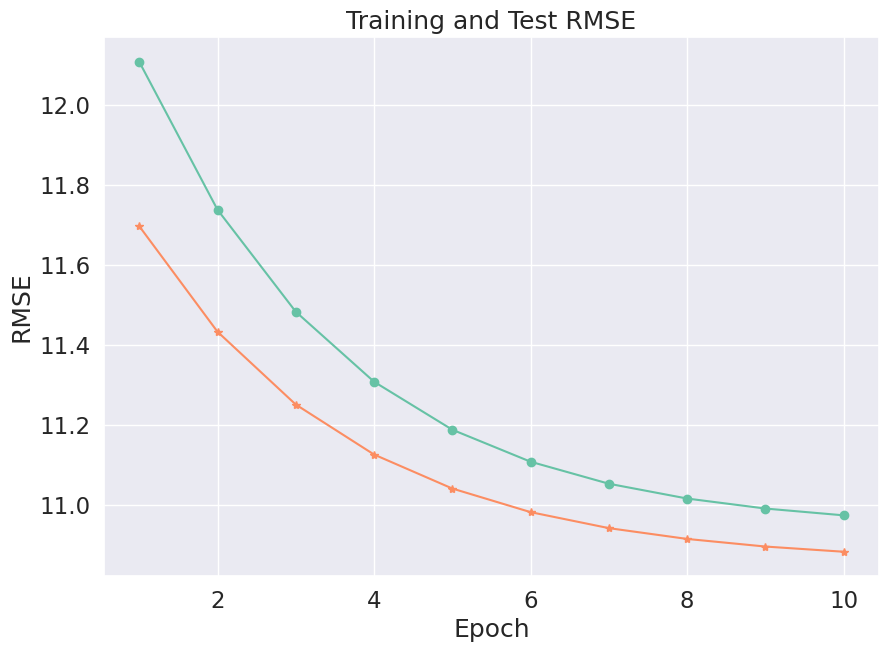

In [41]:
plt.figure(figsize=(10, 7))

plt.plot(range(1, len(train_rmses) + 1), train_rmses, label='Train RMSE', marker='o')
plt.plot(range(1, len(test_rmses) + 1), test_rmses, label='Test RMSE', marker='*')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Test RMSE')